In [97]:
'''
dataset of customer information for an online clothing store,
including age, gender, income, and purchase history. 
We want to group these customers into different clusters
based on their purchasing behavior.
'''

'\ndataset of customer information for an online clothing store,\nincluding age, gender, income, and purchase history. \nWe want to group these customers into different clusters\nbased on their purchasing behavior.\n'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib notebook

### Generate false data with deliberate errors

In [4]:
data = pd.DataFrame({
    'Age': np.random.choice([25, 30, 35, 40, 45, 50, 55, 60, 65, 70], 40000),
    'Income': np.random.choice([25000, 35000, 45000, 55000, 65000, 75000, 85000, 95000], 40000),
    'SpendingScore': np.random.choice([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 40000),
    'ZipCode': np.random.choice(['10001', '20002', '30003', '40004', '50005'], 40000),
    'Country': np.random.choice(['USA', 'Canada', 'UK', 'Germany', 'France'], 40000),
})
# Generate unique ID numbers
num_rows = data.shape[0]
unique_ids = np.random.permutation(num_rows) + 100000  # Add a constant to ensure 6-digit IDs
data['IDNumber'] = unique_ids

# Introduce deliberate errors to practice some data cleaning 
data.loc[10:20, 'Age'] = -1  # Invalid negative age values
data.loc[30:40, 'Income'] = 'unknown'  # Invalid string values for income
data.loc[50:60, 'SpendingScore'] = np.nan  # Missing values for spending score

# Save the dataset as a CSV file
data.to_csv('customer_data.csv', index=False)

### clean and preprocess data

In [5]:
# Handling Missing Data (nan) 
# easy way is to drop the number or fill it with 0 or...
def handle_missing_values(data, strategy='drop', fill_value=0,delete_unknown=True, delete_negative_one=True):
    if strategy == 'drop':
        # Drop rows with any missing values
        data_cleaned = data.dropna()
    elif strategy == 'fill':
        # Fill missing values with the specified fill_value
        if fill_value is None:
            raise ValueError("fill_value must be provided when strategy is 'fill'")
        # Fill missing values with the specified fill_value
        data_cleaned = data.fillna(fill_value)
    elif strategy == 'mean':
        # Fill missing values with the mean of each column
        data_cleaned = data.fillna(data.mean())
    else:
        raise ValueError("Invalid strategy. Options: 'drop', 'fill'")
    # Delete rows with unknown values    
    if delete_unknown:
        data_cleaned = data_cleaned[~data_cleaned.isin(['unknown', 'Unknown', 'UNKNOWN'])]

    # Delete rows with -1 values
    if delete_negative_one:
        data_cleaned = data_cleaned[data_cleaned != -1].dropna()

    return data_cleaned


# we can Create a linear regression model to predict missing values using KNN and using scikit library 

# Removing Duplicates: Duplicated data can be identified and removed to ensure data integrity. 
def remove_duplicates(data, columns=None, keep='first'):
    # Remove duplicates based on specified columns
    data_cleaned = data.drop_duplicates(subset=columns, keep=keep)

    return data_cleaned


datacleaned =handle_missing_values(data)
datacleaned


,Age,Income,SpendingScore,ZipCode,Country,IDNumber
0,65.0,25000,10.0,40004,Canada,123764
1,50.0,65000,70.0,20002,UK,119447
2,25.0,65000,10.0,20002,France,128830
3,45.0,25000,100.0,10001,USA,120207
4,40.0,75000,30.0,30003,Germany,121572
...,...,...,...,...,...,...
39995,70.0,55000,20.0,30003,USA,106893
39996,40.0,75000,40.0,40004,Germany,114096
39997,40.0,85000,50.0,20002,France,116882
39998,40.0,35000,100.0,20002,France,109725


### Handling Outliers

<IPython.core.display.Javascript object>


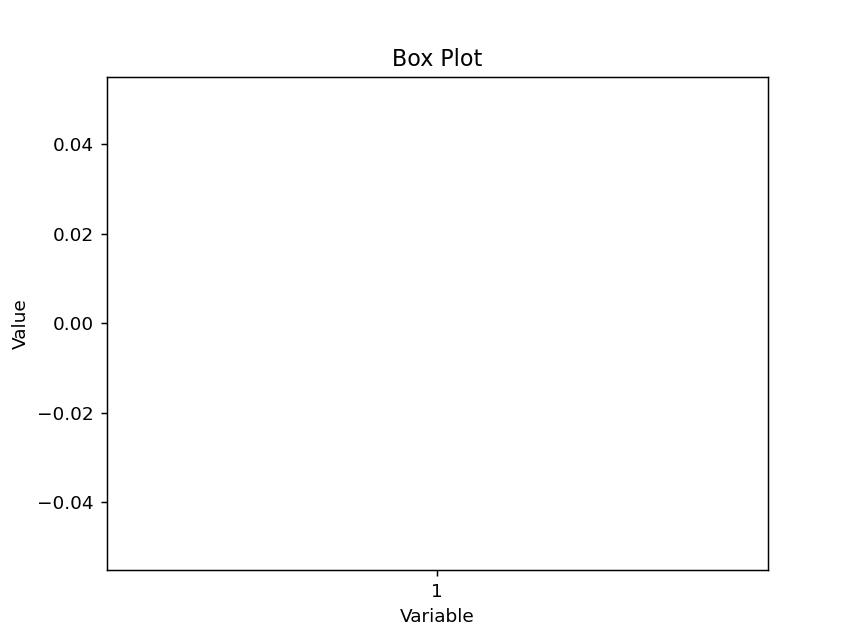

In [6]:
'''
Outliers are strange information points that are very different from most of the other information
so we need to handle them throw: Box plots or Z-score ...etc
'''

# Read the dataset
data = pd.read_csv('customer_data.csv')

# Visualize the data (optional)
# Example: Box plot for 'Income' column
plt.boxplot(data['SpendingScore'])
plt.xlabel('Variable')
plt.ylabel('Value')
plt.title('Box Plot')
plt.show()

### Data formatting

In [7]:
'''
Data formatting means changing the way data looks so that it can be used for things like studying or showing information.
This is done by changing the order, the type, or the values of the data to fit the specific task. 
'''
datacleaned['Income'] = datacleaned['Income'].astype(float)
datacleaned['Country'] = datacleaned['Country'].astype(str)
datacleaned['Age'] = datacleaned['Age'].astype(int)
datacleaned['SpendingScore'] = datacleaned['SpendingScore'].astype(float).round(1)
datacleaned['ZipCode'] = datacleaned['ZipCode'].astype(int)
datacleaned['IDNumber'] = datacleaned['IDNumber'].astype(int)
datacleaned

,Age,Income,SpendingScore,ZipCode,Country,IDNumber
0,65,25000.0,10.0,40004,Canada,123764
1,50,65000.0,70.0,20002,UK,119447
2,25,65000.0,10.0,20002,France,128830
3,45,25000.0,100.0,10001,USA,120207
4,40,75000.0,30.0,30003,Germany,121572
...,...,...,...,...,...,...
39995,70,55000.0,20.0,30003,USA,106893
39996,40,75000.0,40.0,40004,Germany,114096
39997,40,85000.0,50.0,20002,France,116882
39998,40,35000.0,100.0,20002,France,109725


### Data validation

In [8]:
''' 
Common validation checks include 
checking for # missing values
             # data type consistency,
             # range constraints 
             # Sticking to specific pattern or format. 
'''

' \nCommon validation checks include \nchecking for # missing values\n             # data type consistency,\n             # range constraints \n             # Sticking to specific pattern or format. \n'

In [9]:
# a data quality tester to determine the quality of the cleaning function
def test_data_quality(data):
    # Check for NaN values
    nan_count = data.isna().sum().sum()
    if nan_count > 0:
        print(f"Test failed: {nan_count} NaN values found in the DataFrame.")
        return

    # Check for unknown values
    unknown_values = ['unknown', 'Unknown', 'UNKNOWN']
    unknown_count = data.isin(unknown_values).sum().sum()
    if unknown_count > 0:
        print(f"Test failed: {unknown_count} unknown values found in the DataFrame.")
        return

    # Check for -1 values
    negative_one_count = (data == -1).sum().sum()
    if negative_one_count > 0:
        print(f"Test failed: {negative_one_count} -1 values found in the DataFrame.")
        return

    print("Data quality test passed successfully!")
    
    
    
test_data_quality(datacleaned)

Data quality test passed successfully!


In [10]:
# check if there are two ids with same number to avoid that use this tester
def check_duplicate_ids(data):
    duplicate_ids = data['IDNumber'].duplicated()
    if any(duplicate_ids):
        duplicate_rows = data[duplicate_ids]
        duplicate_values = duplicate_rows['IDNumber'].values
        error_message = f"Duplicate IDs found: {', '.join(map(str, duplicate_values))}"
        raise ValueError(error_message)
    else:
        print("Check passed. No duplicate IDs found.")
        
check_duplicate_ids(datacleaned)

Check passed. No duplicate IDs found.


### correlation analysis

In [11]:
'''
We aim to determine relationships between variables
    # create scatter plot 
    # calculate the correlation coefficient 
    # create corelation matrix

'''

'\nWe aim to determine relationships between variables\n    # create scatter plot \n    # calculate the correlation coefficient \n    # create corelation matrix\n\n'

  variances = data.var()


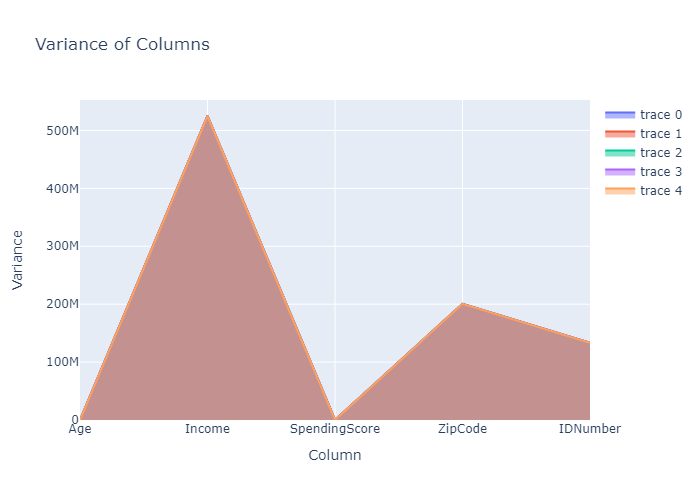

In [12]:
def calculate_and_plot_variance(data):
    # Calculate the variance of each column
    variances = data.var()

    fig = go.Figure()

    # Create the line plot using Plotly
    fig = go.Figure()

    for col in variances.index:
        y_values = [variances[col]] * len(variances.index)  # Create an array-like object with the same value for each index
        fig.add_trace(go.Scatter(x=variances.index, y=variances.values, fill='tozeroy', mode='lines'))

    # Customize the layout
    fig.update_layout(
        title="Variance of Columns",
        xaxis_title="Column",
        yaxis_title="Variance",
        showlegend=True
    )

    # Add a smoothed line
    fig.update_layout(xaxis_title='Column', yaxis_title='Variance')

    # Show the plot
    fig.write_image('variance_plot.png')
  


calculate_and_plot_variance(datacleaned)  
# Display the image in Jupyter Notebook
from IPython.display import Image
Image('variance_plot.png')

### correlation analysis

In [108]:
# we calculate the correlation between the Income of the Person and spending Score to determine the behaviour
correlation_coefficient = datacleaned['Income'].corr(data['SpendingScore'])
formatted_coefficient = round(correlation_coefficient, 4)

# -1 negative correlation, 1 positive correlation, and 0 no correlation.
print("Correlation Coefficient:", formatted_coefficient) # very weak or almost no linear relationship between the variables

Correlation Coefficient: -0.0026


<IPython.core.display.Javascript object>


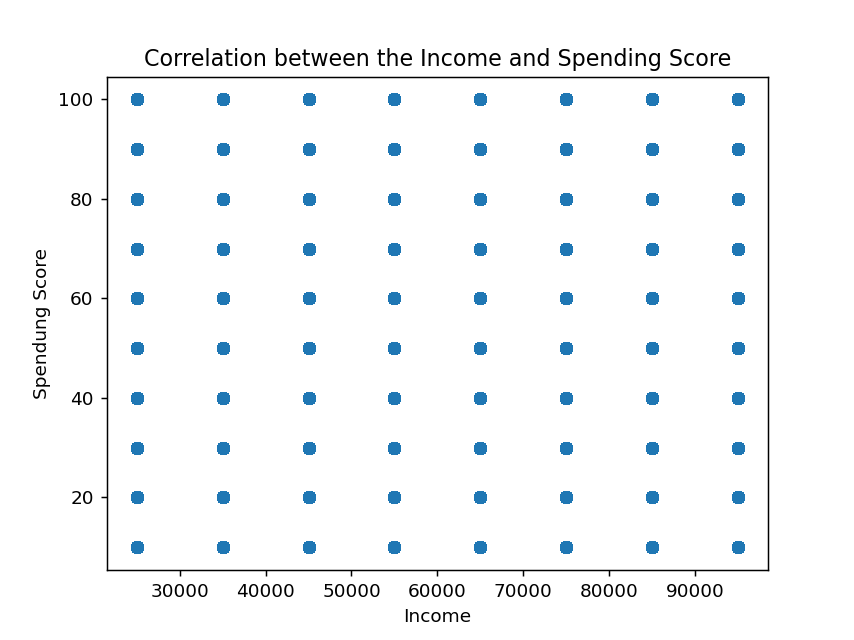

In [121]:
# to see that better we can plot the grap
plt.scatter(datacleaned['Income'], datacleaned['SpendingScore'])
plt.xlabel('Income')
plt.ylabel('Spendung Score')
plt.title('Correlation between the Income and Spending Score')
plt.show()

<IPython.core.display.Javascript object>


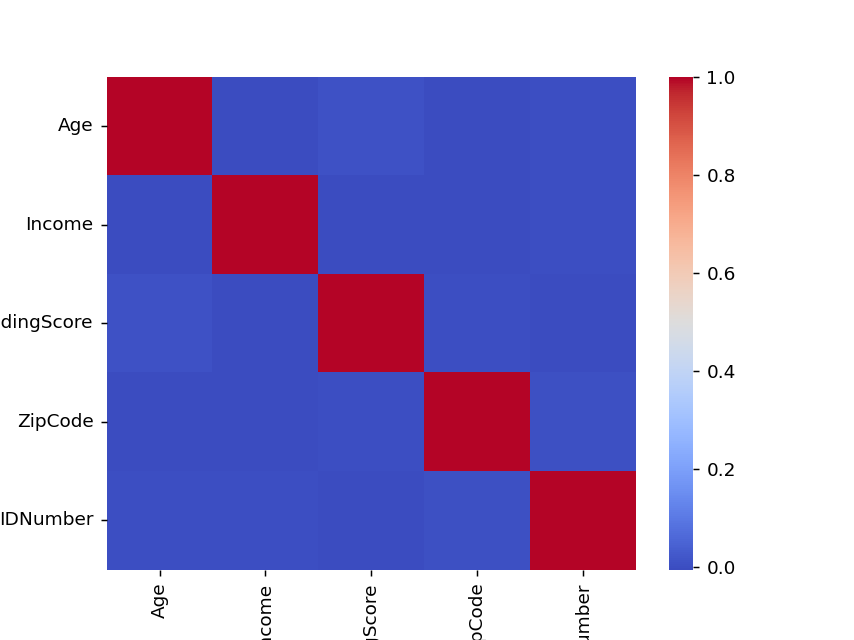

In [120]:
# we could also do correlation matrix which is also helps to see the relation ship between the variables

corr_matr = datacleaned.corr()
sns.heatmap(corr_matr, cmap='coolwarm')
plt.show()

In [2]:

fig = px.scatter(datacleaned, x='Income', y='SpendingScore', color='Age', hover_name='IDNumber',
                 title='Correlation between Income and Spending Score',
                 labels={'Income': 'Income ($)', 'SpendingScore': 'Spending Score', 'Age': 'Age (years)'})

fig.update_layout(
    font=dict(
        family='Arial, sans-serif',
        size=18,
        color='#7f7f7f'
    ),
    legend=dict(
        title='Age (years)',
        yanchor='top',
        y=0.99,
        xanchor='left',
        x=0.01,
        font=dict(
            family='Arial, sans-serif',
            size=14,
            color='#7f7f7f'
        )
    ),
    hoverlabel=dict(
        font_size=16
    ),
    xaxis=dict(
        tickfont=dict(
            family='Arial, sans-serif',
            size=16,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        tickfont=dict(
            family='Arial, sans-serif',
            size=16,
            color='#7f7f7f'
        )
    )
)

fig.show()

NameError: name 'datacleaned' is not defined

In [111]:
'''
# we'll extract the relevant features from the dataset and
# normalize them to have a mean of 0 and a standard deviation of 1:
# Feature scaling ensures that features have similar scales to prevent domination by one feature due to magnitude differences.
# for machine learning purpose for later 
'''
X = datacleaned[['Age', 'Income', 'SpendingScore']].values
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [112]:
#Then, we'll use the k-means algorithm to cluster 
#the data into a specified number of clusters (in this case, 
#let's say 5):
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)


KMeans(n_clusters=5)

In [113]:
#We can then get the cluster assignments for each data point:
labels = kmeans.labels_

#We can also get the coordinates of the cluster centers:
centroids = kmeans.cluster_centers_


In [114]:
#visualize the clusters using a scatter plot:
plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow')
plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=200, linewidths=3, color='black')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()
